In [68]:
%%html
<style>body{--vscode-font-family: "D2Coding"}</style>

In [69]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
from scipy.special import jv, kv, jvp, kvp, jn_zeros, jnp_zeros
from scipy.optimize import fsolve, minimize

# Solving Characteristic equation of Hybrid modes

## Hybrid mode equation

$$
\left[
	\frac{J_q'(u)}{u\,J_q(u)} + \frac{K_q'(w)}{w\,K_q}
\right]
\left[
	\left(
		\frac{n_1}{n_2}
	\right)^2 
	\frac{J_q'(u)}{u\,J_q(u)} + \frac{K_q'(w)}{w\,K_q}
\right]
=
q^2
\left(
	\frac{1}{u^2}+\frac{1}{w^2}
\right) 
\left[
	\left(
		\frac{n_1}{n_2}
	\right)^2 \frac{1}{u^2}+\frac{1}{w^2}
\right]
$$


In [70]:
def gen_eigen_eq(v:float, ncore: float, nclad: float, q: int, **kwargs) -> callable:

  def jf(u):
    return jvp(q, u)/(u*jv(q,u))

  def kf(u):
    w = np.sqrt(v*v - u*u)
    return kvp(q, w)/(w*kv(q,w))

  def qf(u):
    w = np.sqrt(v*v - u*u)
    n_sq= (ncore/nclad)**2
    return q*q*(1/(u*u)+1/(w*w))*(n_sq/(u*u)+1/(w*w))
  
  def hybrid(u):
    n_sq= (ncore/nclad)**2
    return (jf(u)+kf(u))*(n_sq*jf(u)+kf(u))-qf(u)
  
  if kwargs.get("mode")=="hybrid":
    return hybrid

In [71]:
def num_of_zeros_jn(v: float, q: int) -> int:
  count: int = 1
  while jn_zeros(q, count)[-1] < v:
    count += 1
    if count > 100:
      raise ValueError("Too many points of Bessel zeros")
  num = count - 1 
  return num

In [72]:
def get_diverging_points(v: float, q: int) -> list:
  num: int = num_of_zeros_jn(v, q)
  if num ==0:
    return None
  else:
    diverging_points = jn_zeros(q, num)
    return diverging_points

In [73]:
def get_local_minimum(v: float, q: int, eigen_eq: callable):
  step_size = 20
  initial_guesses = np.linspace(jn_zeros(q,1)[-1], v, step_size)
  local_minima = np.array([])

  with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    for guess in initial_guesses:
      result = minimize(eigen_eq, x0=guess)
      if result.success and not any(np.isclose(result.x, [x for x in local_minima], atol=1/step_size)):
        local_minima = np.append(result.x[0], local_minima)
  if np.size(local_minima) == 0:
    return None
  else: return local_minima

In [74]:
def get_init_points_to_solve(v: float, q: int, eigen_eq: callable):
  start = 0.1
  offset = v/100
  init_points = [start]

  local_minimums = get_local_minimum(v, q, eigen_eq)

  if local_minimums is None:
    return init_points
  else:
    for x in local_minimums:
      init_points.append(x - offset)
      init_points.append(x + offset)

  init_points.sort()
  print(f"init points to solve = {init_points}")
  return init_points

In [75]:
def get_roots(v: float, q: int, eigen_eq: callable) -> list:
  init_points = get_init_points_to_solve(v, q, eigen_eq)
  roots = fsolve(eigen_eq, init_points)
  print(roots)
  return roots

In [76]:
def plot_eigen_eq(v, ncore, nclad, q, eigen_eq):

  fig, ax = plt.subplots()

  plot_limit = 1
  ax.set_ylim(-plot_limit, plot_limit)
  ax.hlines(y=0, xmin=0, xmax=v, colors='k', linewidth=0.5) # plot x axis.
  u = np.linspace(0.0001, v-0.0001, int(v*1000))

  ax.set_title(r"Hybrid modes"+f" @V={v:.4f}")
  eigen_plot = eigen_eq(u)
  # eigen_plot= np.where(abs(eigen_plot(u)) >= plot_limit, None, eigen_plot(u))
  ax.plot(u, eigen_plot)
  ax.set_xlabel("$u$")

  # Draw local minimum points of the eigen equation
  local_minima = get_local_minimum(v, q, eigen_eq)
  print(f"local_minimum = {local_minima}")
  ax.vlines(x=local_minima, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='k', alpha=0.5, linewidth=0.9)

  # Draw diverging points 
  # div_points = get_diverging_points(v, q)
  # print(f"diverging_points= {div_points}")
  # ax.vlines(x=div_points, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='g', alpha=0.5, linewidth=0.9)

  # Draw roots
  init_points_to_solve = get_init_points_to_solve(v, q, eigen_eq)
  roots = get_roots(v, q, eigen_eq)
  print(f"Roots={roots}")
  ax.vlines(x=roots, ymin=-plot_limit, ymax=0, linestyles='dashed', colors='r', linewidth=1.0, label="Roots")

  ax.xaxis.set_minor_locator(AutoMinorLocator(5))
  ax.legend(loc=2)

  return (fig, ax)

local_minimum = [16.99700757 14.07893273 11.11176169  8.11023532  5.05329524]
init points to solve = [0.1, 4.853295243136319, 5.25329524313632, 7.9102353203367, 8.3102353203367, 10.911761692239704, 11.311761692239703, 13.878932729303255, 14.278932729303254, 16.797007572179687, 17.197007572179686]
init points to solve = [0.1, 4.853295243136319, 5.25329524313632, 7.9102353203367, 8.3102353203367, 10.911761692239704, 11.311761692239703, 13.878932729303255, 14.278932729303254, 16.797007572179687, 17.197007572179686]
[ 2.2900599   4.88903294  5.25422078  8.00605479  8.22960465 11.19724212
 11.19724212 14.14518505 14.14518472 16.95170094 17.05007961]
Roots=[ 2.2900599   4.88903294  5.25422078  8.00605479  8.22960465 11.19724212
 11.19724212 14.14518505 14.14518472 16.95170094 17.05007961]


C:\Users\jkkow\AppData\Local\Temp\ipykernel_51932\3046149438.py:7: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v*v - u*u)
C:\Users\jkkow\AppData\Local\Temp\ipykernel_51932\3046149438.py:11: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v*v - u*u)


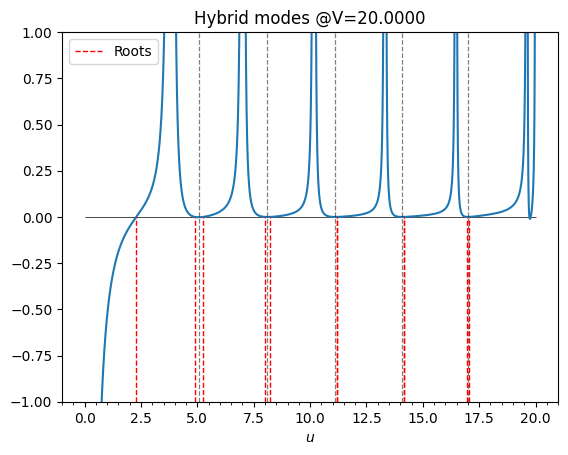

In [77]:
v = 20
na = 0
nclad = 1.444
ncore = np.sqrt(na*na + nclad*nclad)
q = 1

eigen_hybrid = gen_eigen_eq(v, ncore, nclad, q, mode='hybrid')
fig, ax = plot_eigen_eq(v, ncore, nclad, q, eigen_hybrid)